In [1]:
import os
from scipy.io import wavfile
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import Conv2D, MaxPool2D, Flatten, LSTM
from keras.layers import Dropout, Dense, TimeDistributed
from keras.models import Sequential
from keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from tqdm import tqdm
from python_speech_features import mfcc
from cfg import Config
import pickle
from keras.callbacks import ModelCheckpoint

Using TensorFlow backend.


In [2]:
def check_data():
    if os.path.isfile(config.p_path):
        print('loading existing data for {} model'.format(config.mode))
        with open(config.p_path, 'rb') as handle:
            tmp = pickle.load(handle)
            return tmp
    else:
        return None       

In [3]:
def build_rand_feat():
    tmp = check_data()
    if tmp:
        return tmp.data[0], tmp.data[1]
    X = []
    y = []
    _min, _max = float('inf'), -float('inf')
    for _ in tqdm(range(n_samples)):
        rand_class = np.random.choice(class_dist.index, p=prob_dist)
        file = np.random.choice(df[df.label==rand_class].index)
        rate, wav = wavfile.read('clean/'+file)
        label = df.at[file, 'label']
        rand_index = np.random.randint(0, wav.shape[0]-config.step)
        sample = wav[rand_index:rand_index+config.step]
        X_sample = mfcc(sample,rate,
                       numcep=config.nfeat, nfilt=config.nfilt,nfft=config.nfft)
        _min = min(np.amin(X_sample), _min)
        _max = max(np.amax(X_sample), _max)
        X.append(X_sample)  
        y.append(classes.index(label))
    config.min = _min
    config.max = _max 
    X, y = np.array(X), np.array(y)
    X = (X - _min)/(_max - _min)
    
    if config.mode == 'conv':
        X =X.reshape(X.shape[0],X.shape[1],X.shape[2],1)
    elif config.mode == 'time':
        X = X.reshape(X.shape[0],X.shape[1],X.shape[2])
    y = to_categorical(y, num_classes = 10)
    config.data =(X,y)
    
    with open(config.p_path, 'wb') as handle:
        pickle.dump(config, handle, protocol =2)
        

    return X,y


In [4]:
def get_conv_model():
    model = Sequential()
    model.add(Conv2D(16,(3,3), activation ="relu",strides=(1,1), padding='same',input_shape=input_shape))
    model.add(Conv2D(32,(3,3), activation ="relu",strides=(1,1), padding='same'))
    model.add(Conv2D(64,(3,3), activation ="relu",strides=(1,1), padding='same'))
    model.add(Conv2D(128,(3,3), activation ="relu",strides=(1,1), padding='same'))
    model.add(MaxPool2D((2,2)))
    model.add(Dropout(0.5))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model

In [5]:
def get_recurrent_model():
    model = Sequential()
    model.add(LSTM(128, return_sequences = True,input_shape = input_shape))
    model.add(LSTM(128, return_sequences = True))
    model.add(Dropout(0.5))
    model.add(TimeDistributed(Dense(64, activation ='relu')))
    model.add(TimeDistributed(Dense(32, activation ='relu')))
    model.add(TimeDistributed(Dense(16, activation ='relu')))
    model.add(TimeDistributed(Dense(8, activation ='relu')))
    model.add(Flatten())
    model.add(Dense(10, activation='softmax'))
    model.summary()
    model.compile(loss='categorical_crossentropy',
                 optimizer='adam',
                 metrics=['acc'])
    return model

In [6]:
df = pd.read_csv('instruments.csv')
df.set_index('fname', inplace=True)

In [7]:
for f in df.index:
    rate, signal = wavfile.read('clean/'+f)
    df.at[f, 'length'] = signal.shape[0]/rate


In [8]:
classes = list(np.unique(df.label))
class_dist = df.groupby(['label'])['length'].mean()


In [9]:
n_samples = 2*int(df['length'].sum()/0.1)
prob_dist = class_dist/class_dist.sum()
chioces = np.random.choice(class_dist.index, p=prob_dist)

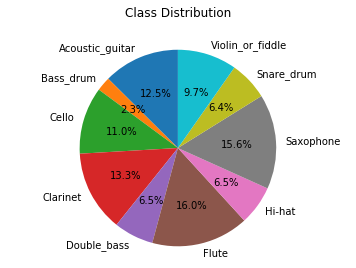

In [10]:
fig, ax = plt.subplots()
ax.set_title('Class Distribution', y=1.08)
ax.pie(class_dist, labels=class_dist.index, autopct='%1.1f%%',
       shadow=False, startangle=90)
ax.axis('equal')
plt.show()

In [11]:
config = Config(mode='time')##

if config.mode == 'conv':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1],X.shape[2],1)
    model = get_conv_model()

elif config.mode == 'time':
    X, y = build_rand_feat()
    y_flat = np.argmax(y, axis=1)
    input_shape = (X.shape[1], X.shape[2])
    model = get_recurrent_model()
    
class_weight = compute_class_weight('balanced',
                                   np.unique(y_flat),
                                   y_flat)

checkpoint = ModelCheckpoint(config.model_path, monitor ='val_acc',verbose=1, mode ='max',
                             save_best_only = True, save_weights_only = False , period=1)

model.fit(X,y,epochs=10, batch_size=32,
          shuffle = True,validation_split = 0.1,
          callbacks=[checkpoint])

model.save(config.model_path)


100%|██████████| 26410/26410 [01:08<00:00, 386.47it/s]


Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (None, 9, 128)            72704     
_________________________________________________________________
lstm_2 (LSTM)                (None, 9, 128)            131584    
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 128)            0         
_________________________________________________________________
time_distributed_1 (TimeDist (None, 9, 64)             8256      
_________________________________________________________________
time_distributed_2 (TimeDist (None, 9, 32)             2080      
_________________________________________________________________
time_distributed_3 (T